In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS
from statsforecast.arima import arima_string
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
class FixedCESProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecast = None
        self.plotting_df = pd.DataFrame()
        
        self.mae = None
        self.mse = None
        self.mape = None
        self.nmse = None
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_fixed_model(self, h, freq, season_length, model_name, level = []):
        
        if not self.sf:
            self.sf = StatsForecast(models=[AutoCES(season_length=season_length)], freq = freq)
            self.sf.fit(self.dfs[0])
            self.sf.save(f"AutoCES/fixed_models/{model_name}.pkl")
        
        start_date = datetime.strptime(self.dates[0], "%Y-%m-%d")
        ending_date = datetime.strptime(self.dates[-1], "%Y-%m-%d") + timedelta(weeks = h)

        prediction_horizon = abs((ending_date - start_date).days) // 7
        
        if not level:
            self.forecast = self.sf.predict(h = prediction_horizon)
        else:
            self.forecast = self.sf.predict(h = prediction_horizon, level = level)

        self.forecast.set_index("ds", inplace = True)
        self.forecast.drop(columns = "unique_id", inplace = True)
        
    def load_model(self, path):
        self.sf = StatsForecast.load(path = path)
        
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "CES":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['CES'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    def create_graph(self):
        if len(self.forecast.columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecast.columns)
    
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))
        
        for col in self.forecast.columns:
            if "hi" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         line = dict(color = self.color_mapping[number])))
                                         
        for col in self.forecast.columns:
            if "lo" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
        for col in self.forecast.columns:
            if col == "CES":
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["CES"])))
        
        fig.update_layout(title = f"Fixed Parameter CES Predictions, {self.dates[0]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
        fig.show()

    
    def create_metrics(self):
        col_string = "CES"

        
        self.mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.nmse = self.mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecast.index])

    def create_metrics_df(self):
        self.metrics_df.loc[len(self.metrics_df)] = [self.dates[0], self.mae, self.mse, self.mape, self.nmse]
    
    def create_display_df(self):
        for index, row in self.forecast.iterrows():
            reference_date = self.dates[0]
            target_end_date = index
            
            for col in self.forecast.columns:
                value = self.forecast.loc[target_end_date, col]
                if "lo" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = alpha / 2
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                if col == "CES":
                    quantile = 0.5
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                elif "hi" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = 1 - (alpha / 2)
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
        
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [4]:
class UpdatingCESProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
            
    def create_models(self, h, freq, season_length, model_names, level = []):
        
        if not self.sfs:
            for i in range(len(self.dfs)):
                sf = StatsForecast(models=[AutoCES(season_length=season_length)], freq = freq)
                sf.fit(self.dfs[i])
                self.sfs.append(sf)
                sf.save(f"AutoCES/updating_models/{model_names[i]}.pkl")
        

        for i in range(len(self.dfs)):
            fc = pd.DataFrame()
            if not level:
                fc = self.sfs[i].predict(h = h)
            else:
                fc = self.sfs[i].predict(h = h, level = level)
            
            fc.set_index("ds", inplace = True)
            fc.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(fc)
    
    
    def load_models(self, paths):
        for i in range(len(paths)):
            sf = StatsForecast.load(path = paths[i])
            self.sfs.append(sf)
    
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "CES":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['CES'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            for col in self.forecasts[i].columns:
                if col == "CES":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["CES"])))
                    
            fig.update_layout(title = f"Updating Parameter CES Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
    def calculate_metrics(self):
        col_string = "CES"
  
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "CES":
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [5]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [7]:
Processor = FixedCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [8]:
Processor.create_training_dfs(value_col = "value")

In [9]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

Saving StatsForecast object of size 10.70KB.
StatsForecast object saved


In [10]:
Processor.forecast

,CES,CES-lo-95,CES-lo-80,CES-hi-80,CES-hi-95
ds,,,,,
2024-10-12,265.220703,-3071.073621,-1836.849097,2412.015356,3555.930682
2024-10-19,505.310547,-2792.130212,-1649.338013,2619.863745,3710.798132
2024-10-26,1358.358398,-1790.233093,-736.262988,3425.373218,4534.298486
2024-11-02,2509.965942,-600.974445,484.014404,4548.643555,5749.773267
2024-11-09,3855.705811,773.592752,1837.633057,5875.318750,6958.187109
2024-11-16,5251.941162,2259.636230,3247.656616,7232.955469,8329.624512
2024-11-23,9162.954346,6186.325146,7188.100391,11073.880176,12078.498218
2024-11-30,14165.786865,11319.043872,12293.961816,16055.457520,17053.645801
2024-12-07,13494.167969,10703.777734,11643.491113,15349.601562,16348.080640


In [11]:
Processor.create_graph()

/tmp/ipykernel_24549/473455151.py:62: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [12]:
Processor.create_metrics()

In [13]:
Processor.create_metrics_df()

In [14]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,5264.797316,7.057161e+07,0.83335,0.540879


In [15]:
Processor.create_display_df()

In [16]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3071.073621
2,2024-10-05,2024-10-12,0.100,-1836.849097
0,2024-10-05,2024-10-12,0.500,265.220703
3,2024-10-05,2024-10-12,0.900,2412.015356
4,2024-10-05,2024-10-12,0.975,3555.930682
...,...,...,...,...
61,2024-10-05,2025-01-04,0.025,11471.782690
62,2024-10-05,2025-01-04,0.100,12362.820898
60,2024-10-05,2025-01-04,0.500,14093.265381
63,2024-10-05,2025-01-04,0.900,15888.246484


In [17]:
Processor2 = FixedCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [18]:
Processor2.create_training_dfs(value_col="value")

In [19]:
Processor2.load_model(path = "AutoCES/fixed_models/testing.pkl")

In [20]:
Processor2.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

In [21]:
Processor2.create_display_df()

In [22]:
Processor2.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3071.073621
2,2024-10-05,2024-10-12,0.100,-1836.849097
0,2024-10-05,2024-10-12,0.500,265.220703
3,2024-10-05,2024-10-12,0.900,2412.015356
4,2024-10-05,2024-10-12,0.975,3555.930682
...,...,...,...,...
61,2024-10-05,2025-01-04,0.025,11471.782690
62,2024-10-05,2025-01-04,0.100,12362.820898
60,2024-10-05,2025-01-04,0.500,14093.265381
63,2024-10-05,2025-01-04,0.900,15888.246484


In [23]:
Processor2.display_df.equals(Processor.display_df)

True

In [24]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [25]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [26]:
UProcessor = UpdatingCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [27]:
UProcessor.create_training_dfs(value_col = "value")

In [28]:
UProcessor.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

Saving StatsForecast object of size 10.70KB.
StatsForecast object saved
Saving StatsForecast object of size 10.80KB.
StatsForecast object saved
Saving StatsForecast object of size 10.90KB.
StatsForecast object saved
Saving StatsForecast object of size 11.00KB.
StatsForecast object saved
Saving StatsForecast object of size 12.22KB.
StatsForecast object saved


/tmp/ipykernel_24549/2026481641.py:67: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



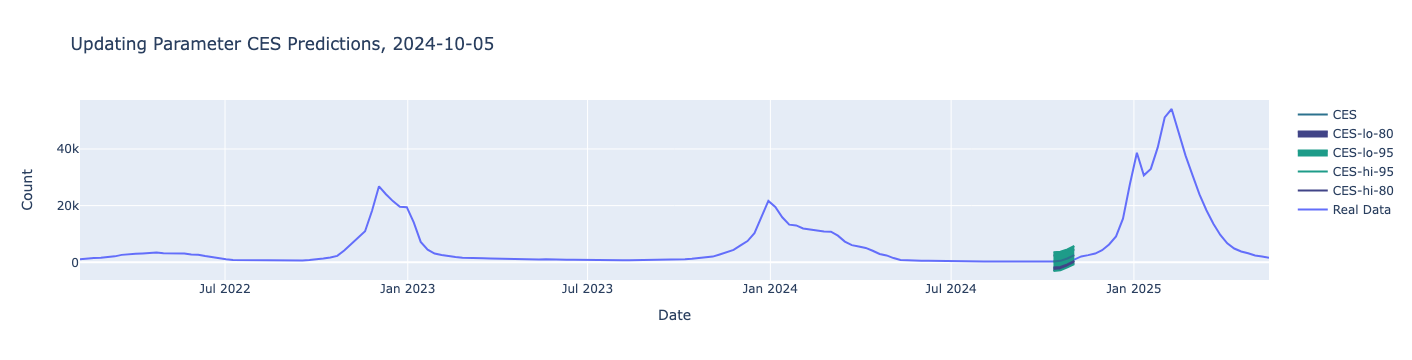

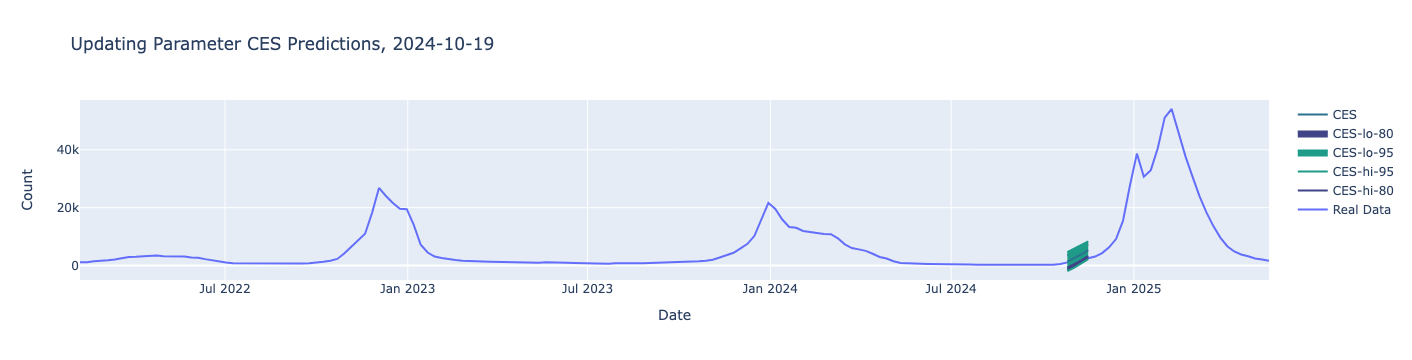

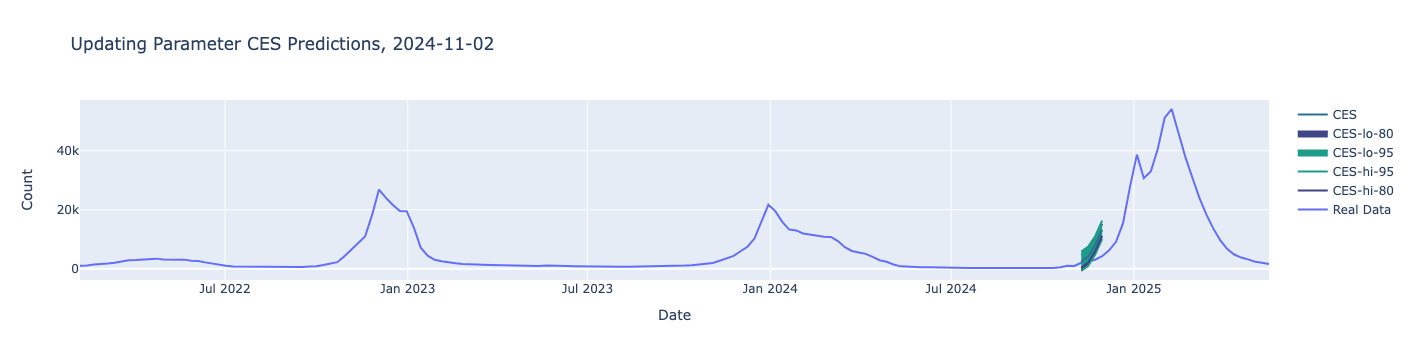

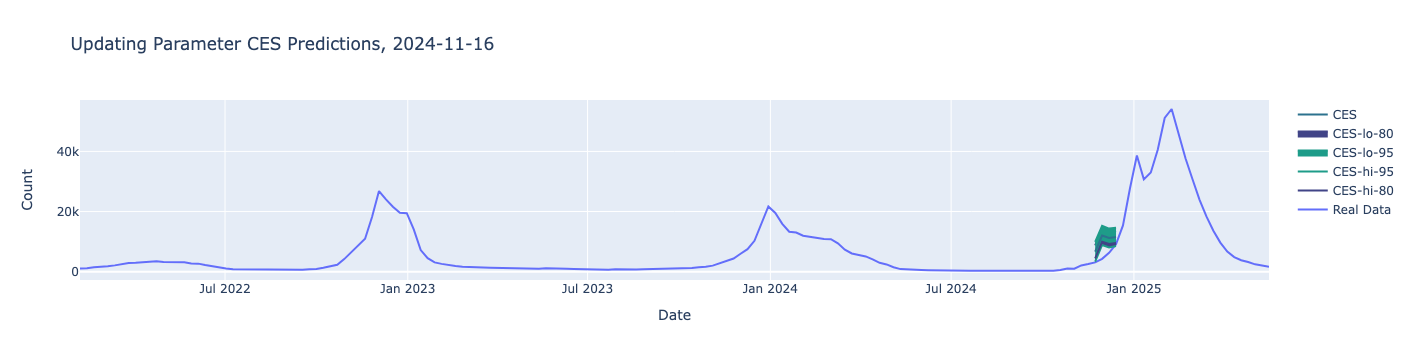

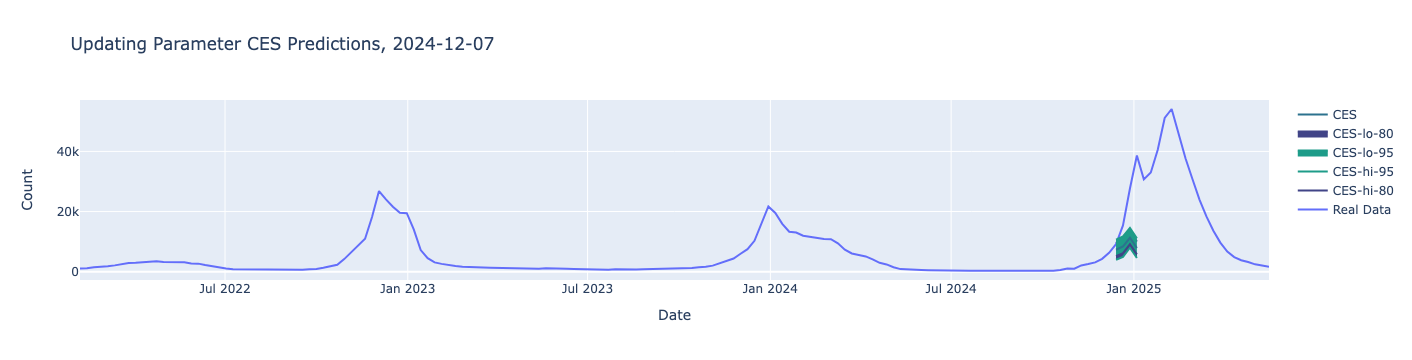

In [29]:
UProcessor.create_graph()

In [30]:
UProcessor.calculate_metrics()

In [31]:
UProcessor.create_metrics_df()

In [32]:
UProcessor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,470.948273,6.092151e+05,0.499227,5.962394
1,2024-10-19,1600.827606,3.338131e+06,0.956932,7.696366
2,2024-11-02,4000.271805,2.676559e+07,1.142369,39.410045
3,2024-11-16,4639.323540,2.555697e+07,0.999288,4.845129
4,2024-12-07,14016.387848,3.175194e+08,0.511964,2.459157


In [33]:
UProcessor.create_display_df()

In [34]:
UProcessor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3071.073621
2,2024-10-05,2024-10-12,0.100,-1836.849097
0,2024-10-05,2024-10-12,0.500,265.220703
3,2024-10-05,2024-10-12,0.900,2412.015356
4,2024-10-05,2024-10-12,0.975,3555.930682
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,4551.230505
97,2024-12-07,2025-01-04,0.100,5778.587500
95,2024-12-07,2025-01-04,0.500,7865.406372
98,2024-12-07,2025-01-04,0.900,10008.989844


In [35]:
UProcessor2 = UpdatingCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [36]:
UProcessor2.create_training_dfs(value_col="value")

In [37]:
model_paths = ["AutoCES/updating_models/test1.pkl", "AutoCES/updating_models/test2.pkl", "AutoCES/updating_models/test3.pkl", 
               "AutoCES/updating_models/test4.pkl", "AutoCES/updating_models/test5.pkl"]
UProcessor2.load_models(paths = model_paths)

In [38]:
UProcessor2.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

In [39]:
UProcessor2.create_display_df()

In [40]:
UProcessor2.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3071.073621
2,2024-10-05,2024-10-12,0.100,-1836.849097
0,2024-10-05,2024-10-12,0.500,265.220703
3,2024-10-05,2024-10-12,0.900,2412.015356
4,2024-10-05,2024-10-12,0.975,3555.930682
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,4551.230505
97,2024-12-07,2025-01-04,0.100,5778.587500
95,2024-12-07,2025-01-04,0.500,7865.406372
98,2024-12-07,2025-01-04,0.900,10008.989844


In [41]:
UProcessor.display_df.equals(UProcessor2.display_df)

True